In [55]:
'''
This file will compute the EOM then solve them with and without a Shaper to get
graphs.
'''

from sympy import symbols, init_printing
import sympy
import sympy.physics.mechanics as me
init_printing(use_latex='mathjax')
import seaborn as sns
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import matplotlib.pyplot as plt
from scipy.integrate import ode, odeint
import numpy as np
import InputShaping as shaping
%matplotlib inline

# Create the variables
x, y, beta = me.dynamicsymbols('x, y, beta')

# Create the velocities
x_dot, y_dot, beta_dot = me.dynamicsymbols('x, y, beta', 1)

# Create the constants
m, k, L, g, H, c, D, t = sympy.symbols('m k L g H c D t')
Izz, k_beta, c_beta = sympy.symbols('Izz k_beta c_beta')
L_1_init, L_2_init = sympy.symbols('L_1_init L_2_init')
'''
m = mass
k = spring k
L = spring equilibrium length
g = gravity
c = spring c
c_beta = rotational c
k_beta = rotational k
D = rod length
Izz = moment of Inertia about the end of a rod
'''

# Create the world frame
N = me.ReferenceFrame('N')

# Create the rod frame
B = N.orientnew('B', 'axis', [beta, -N.z])

# Set the rotation of the rod frame
B.set_ang_vel(N, beta_dot * -N.z)

# Create the Origin
O1 = me.Point('O_1')

# Set origin velocity to zero
O1.set_vel(N, 0 * N.x)

# Create the second attachment point
# O2 = O1.locatenew('O_2', H * N.x)
O2 = me.Point('O_2')
O2.set_pos(O1, H * N.x)
O2.set_vel(N, 0)

# Locate the point in the N frame
# P = me.Point('pen')
# P = O1.locatenew('P', x * N.x + y * N.y)
P = me.Point('P')
P.set_pos(O1, x * N.x + y * N.y)
P.set_pos(O2, -(H - x) * N.x + y * N.y)

# P.set_pos(O1, x * N.x + y * N.y)

# Set the point's velocity
P.set_vel(N, x_dot * N.x + y_dot * N.y)

# Create the rod center of mass
G = P.locatenew('G', D/2 * B.y)

# Set the velocity of G
G.v2pt_theory(P, N, B)

# Create the rod
I_rod = me.inertia(B, 0, 0, Izz)
rod = me.RigidBody('rod', G, B, m, (I_rod, G))

# Create the distance from the point to each attachment point
L1 = O1.pos_from(P).magnitude
L2 = O2.pos_from(P).magnitude
L1_vector = O1.pos_from(P).normalize
L2_vector = O2.pos_from(P).normalize

# Create the height from the center of gravity to the datum
h = G.pos_from(O1) & N.y

# The forces at the connection point
forceP = c * (x_dot + y_dot) * L1_vector() + c * (-x_dot + y_dot) * L2_vector()

# The forces on the beta frame
forceB = -c_beta * beta_dot * N.z

rod.potential_energy = (-m * g * h + 0.5 * k * (L1() - L_1_init)**2 + 0.5 *
                        k *(L2() - L_2_init)**2 + 0.5 * k_beta * beta**2)

Lag = me.Lagrangian(N, rod)

LM = me.LagrangesMethod(Lag, [x, y, beta], forcelist=[(P, forceP), (B, forceB)], frame=N)


EqMotion = LM.form_lagranges_equations()

lrhs = LM.rhs()
# print(lrhs)

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


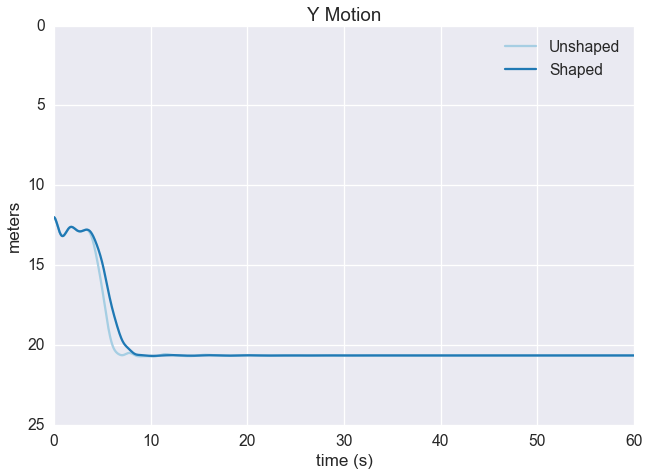

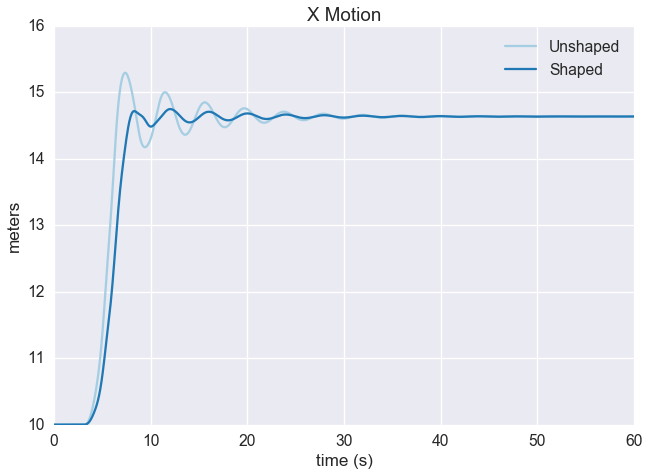

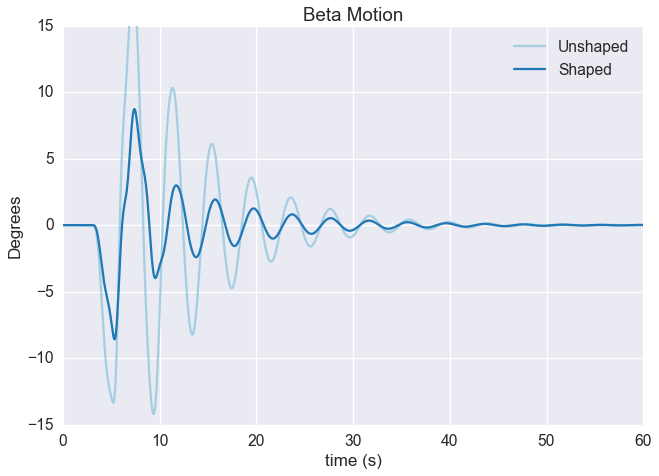

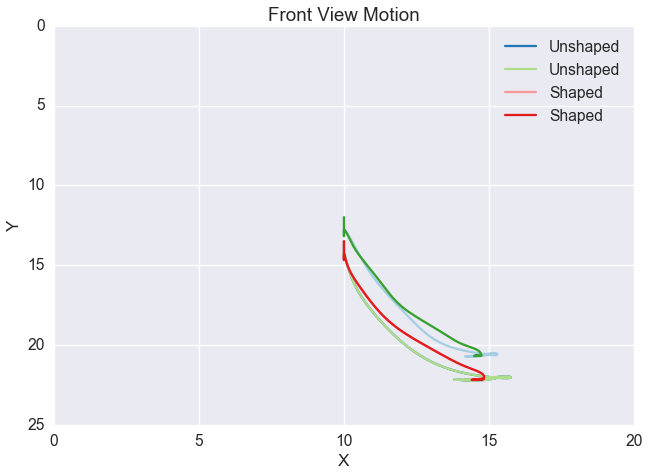

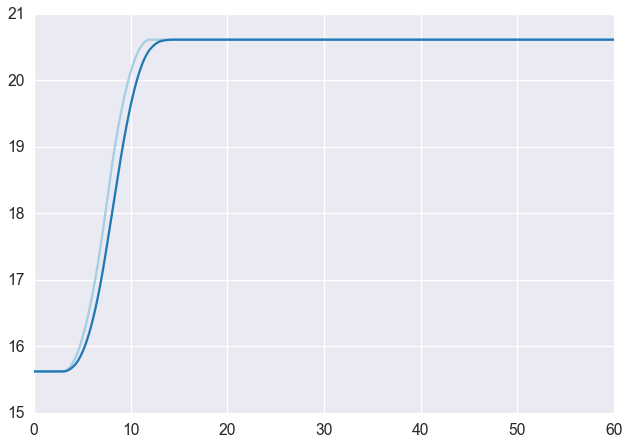

In [56]:
def s_curve(CurrTime, Begin, Amp, RiseTime, StartTime):
    """
    This was copied from Dr. Vaughan's Input shaping Library
    I edited it to allow for a beginning value.

    Function to generate an s-curve command

    Arguments:
      CurrTime : The current timestep or an array of times
      Amp : The magnitude of the s-curve (or final setpoint)
      RiseTime : The rise time of the curve
      StartTime : The time that the command should StartTime
      Begin : The beginnning value

    Returns :
      The command at the current timestep or an array representing the command
      over the times given (if CurrTime was an array)
    """

    Amp = Amp - Begin
    scurve = 2.0 * ((CurrTime - StartTime)/RiseTime)**2 * (CurrTime-StartTime >= 0) * (CurrTime-StartTime < RiseTime/2)+(-2.0 * ((CurrTime - StartTime)/RiseTime)**2 + 4.0 * ((CurrTime - StartTime)/RiseTime) - 1.0) * (CurrTime-StartTime >= RiseTime/2) * (CurrTime-StartTime < RiseTime)    + 1.0 * (CurrTime-StartTime >= RiseTime)

    return (Amp * scurve) + Begin


# Various Shapers

# Going with 500rpm
# example_shaper = shaping.EI(0.329, 0.101)
example_shaper = shaping.EI(0.4323345411805539, 0.25)
# example_shaper = shaping.ZVD(0.32, 0.032272678421545214)
# example_shaper = shaping.ZV_EI_2mode(.466053, 0.032272, .466053, 0.032272)
# example_shaper = shaping.UMZVD(.46605358040201028, 0.032272678421545214)
# example_shaper = shaping.ZVD_2mode(0.40160804, 0.07159188, 0.047746, 0.0)
Shaper = example_shaper.shaper

# a = shaping.shaped_input(s_curve, t, Shaper, 10.0,13.0,5.0,3.0)


length_of_rod = 3.0
mass = 1.0
inertia = length_of_rod * (1.0/3.0) * mass

############### UNSHAPED #####################################################

# Define the states and state vector
w1, w2, w3, w4, w5, w6 = sympy.symbols('w1 w2 w3 w4 w5 w6', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t), w5(t), w6(t)]

# Set up the state definitions and parameter substitution
sub_params = {x : w1(t),
              y : w2(t),
              beta: w3(t),
              x_dot: w4(t),
              y_dot: w5(t),
              beta_dot: w6(t),
              m : mass,
              g : 9.81,
              k : 10.0,
              L_1_init:s_curve(t, 15.62, 25.0, 4.0, 3.0),
              L_2_init:s_curve(t, 15.62, 20.61, 4.0, 3.0),
              H : 20.0,
              c : 1.0,
              D : length_of_rod,
              Izz: inertia,
              k_beta: 0.1,
              c_beta: 0.01}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w),
                              lrhs.subs(sub_params),
                              modules = mat2array)


# In[32]:

end_time = 60.0

x0 = [10, 12, 0.0, 0.0, 0.0, 0.0]

# Positive beta is to the left when facing the structure
sim_time = np.linspace(0.0, end_time, 1000)


# In[33]:

# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])

# define the sample time
dt = sim_time[1] - sim_time[0]

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t < sim_time[-1]:
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

# np.savetxt("response.csv", response, delimiter=",")
# np.savetxt("response_shaped.csv", response2, delimiter=",")
# np.savetxt("sim_time.csv", sim_time, delimiter=",")

#############################################################################

############### SHAPED ######################################################

# Define the states and state vector
w1, w2, w3, w4, w5, w6 = sympy.symbols('w1 w2 w3 w4 w5 w6', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t), w5(t), w6(t)]

# Set up the state definitions and parameter substitution
sub_params = {x : w1(t),
              y : w2(t),
              beta: w3(t),
              x_dot: w4(t),
              y_dot: w5(t),
              beta_dot: w6(t),
              m : mass,
              g : 9.81,
              k : 10.0,
              L_1_init: shaping.shaped_input(s_curve, t, Shaper, 15.62,25,4.0,3.0),
              L_2_init: shaping.shaped_input(s_curve, t, Shaper, 15.62,20.61,4.0,3.0),
              H : 20.0,
              c : 1.0,
              D : length_of_rod,
              Izz: inertia,
              k_beta: 1.0,
              c_beta: 1.0}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w),
                              lrhs.subs(sub_params),
                              modules = mat2array)


# In[32]:

end_time = 60.0

x0 = [10, 12, 0.0, 0.0, 0.0, 0.0]

# Positive beta is to the left when facing the structure
sim_time = np.linspace(0.0, end_time, 1000)


# In[33]:

# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])

# define the sample time
dt = sim_time[1] - sim_time[0]

# pre-populate the response array with zeros
response2 = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t < sim_time[-1]:
    response2[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1
# In[34]:

#############################################################################


sns.set_palette("Paired")
sns.set_context("talk", font_scale=1.2)
# sns.set_style("darkgrid")

plt.figure(0)
# plt.subplot(211)
plt.plot(sim_time, response[:,1], label='Unshaped')
plt.plot(sim_time, response2[:,1], label ='Shaped')
plt.ylim(25,0)
plt.legend()
plt.title('Y Motion')
plt.xlabel('time (s)')
plt.ylabel('meters')
plt.show()

plt.figure(1)
# plt.subplot(211)
plt.plot(sim_time, response[:,0], label='Unshaped')
plt.plot(sim_time, response2[:,0], label ='Shaped')
plt.legend()
plt.title('X Motion')
plt.xlabel('time (s)')
plt.ylabel('meters')
plt.show()

plt.figure(2)
# plt.subplot(211)
plt.plot(sim_time, np.degrees(response[:,2]), label='Unshaped')
plt.plot(sim_time, np.degrees(response2[:,2]), label ='Shaped')
plt.legend()
# plt.plot(sim_time, np.degrees(response2[:,2]))
plt.ylim(-15,15)
plt.xlim(0,60)
plt.title('Beta Motion')
plt.xlabel('time (s)')
plt.ylabel('Degrees')
# plt.savefig("Beta_Motion.pdf")
plt.show()

plt.figure(3)
# plt.subplot(212)

x_un = response[:,0]
y_un = response[:,1]

xp_un = response[:,0] + length_of_rod/2 * np.sin(response[:,2])
yp_un = response[:,1] + length_of_rod/2 * np.cos(response[:,2])

xend_un = response[:,0] + length_of_rod/2 * np.sin(response[:,2])
yend_un = response[:,1] + length_of_rod/2 * np.cos(response[:,2])

plt.plot(x_un, y_un)
plt.plot(xp_un, yp_un, label='Unshaped')
plt.plot(xend_un, yend_un, label='Unshaped')

x_s = response2[:,0]
y_s = response2[:,1]

xp_s = response2[:,0] + length_of_rod/2 * np.sin(response2[:,2])
yp_s = response2[:,1] + length_of_rod/2 * np.cos(response2[:,2])

xend_s = response2[:,0] + length_of_rod/2 * np.sin(response2[:,2])
yend_s = response2[:,1] + length_of_rod/2 * np.cos(response2[:,2])

plt.plot(x_s, y_s)
plt.plot(xp_s, yp_s, label='Shaped')
plt.plot(xend_s, yend_s, label='Shaped')

plt.legend()
plt.title('Front View Motion')
# plt.ylim(25,0)
plt.ylim(25,0)
# plt.xlim(0,20)
plt.xlim(0,20)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure(4)
plt.plot(sim_time, s_curve(sim_time, 15.62, 20.61, 9.0, 3.0))
plt.plot(sim_time, shaping.shaped_input(s_curve, sim_time, Shaper, 15.62,20.61,9.0,3.0))
plt.show()

(0, 20)

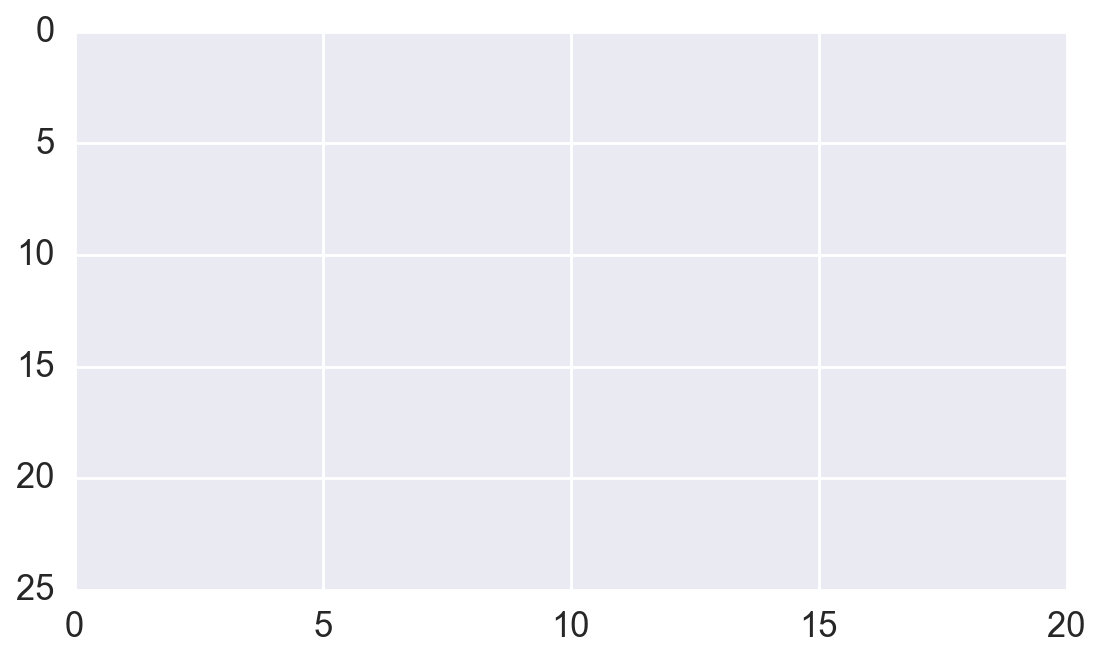

In [57]:
# Unshaped
import matplotlib.animation as animation

# Change some plot properties to make the video work and look better
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 160
mpl.rcParams['savefig.bbox'] = 'standard'
fig = plt.figure(figsize=(8,4.5))

leftcable, = plt.plot([],[], linewidth=2, linestyle = '-', label='leftcable')
rightcable, = plt.plot([],[], linewidth=2, linestyle = '-', label='rightcable')
barLine, = plt.plot([],[], linewidth=6, linestyle = '-', label='Bar')

plt.ylim(25,0)
plt.xlim(0,20)

In [62]:
def init():
    """ Initialize the lines in the plot """
    leftcable.set_data([], [])
    rightcable.set_data([], [])
    barLine.set_data([],[])
    
    return barLine, leftcable, rightcable,

In [63]:
def animate_un(i):
    """ Update the plot for frame i """
    if not (i % 30): # print notice every 30th frame
        print('Processing frame {}'.format(i))
        
    rightcable.set_data([0, x_un[i]], [0, y_un[i]])
    leftcable.set_data([20, x_un[i]], [0, y_un[i]])
    barLine.set_data([x_un[i], xend_un[i]], [y_un[i], yend_un[i]])
    
    return barLine, leftcable, rightcable,

In [64]:
def animate_s(i):
    """ Update the plot for frame i """
    if not (i % 30): # print notice every 30th frame
        print('Processing frame {}'.format(i))
        
    rightcable.set_data([0, x_s[i]], [0, y_s[i]])
    leftcable.set_data([20, x_s[i]], [0, y_s[i]])
    barLine.set_data([x_s[i], xend_s[i]], [y_s[i], yend_s[i]])
    
    return barLine, leftcable, rightcable,

In [67]:
ani_un = animation.FuncAnimation(fig, animate_un, interval = 30, frames = 300, blit = True, init_func = init)
ani_s = animation.FuncAnimation(fig, animate_s, interval = 30, frames = 300, blit = True, init_func = init)

In [68]:
# ani_un.save('unshaped.mp4', bitrate = 2500, fps = 30)
ani_s.save('shaped.mp4', bitrate = 2500, fps = 30)

Processing frame 0
Processing frame 30
Processing frame 60
Processing frame 90
Processing frame 120
Processing frame 150
Processing frame 180
Processing frame 210
Processing frame 240
Processing frame 270


In [ ]:
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['savefig.bbox'] = 'tight'